## VAE Hawkes Process Estimation - Tutorial

In [1]:
import os

import numpy as np
import pandas as pd
import scienceplots

import matplotlib.pyplot as plt

from dl.mlp_model import MLPTrainer
import variables.prep_var as prep

from evaluation.eval import compute_errors
from hawkes.simulation import hawkes_simulations, hawkes_simulation
from hawkes.discretisation import discretise
from visualization.delta_effect import delta_simulations
from hawkes.hyperparameters import hyper_params_simulation
from tools.utils import write_parquet, read_parquet, timer
from visualization.model_effect import convergence_rate, error_boxplots
from preprocessing.dataset import split_data, create_datasets, create_data_loaders

%load_ext autoreload
%autoreload 2

### Preprocessing

In [146]:
# Training/Validation/Testing dataset generation

# Intensity Decay Parameter (β) = U(p = 1, q = 3)
# Branching Ratio (η) = U(a = 0.05, b = 0.8)
# Expected Activity (E) = 500
# Time Horizon (T) = 100
# Interval Length (∆) = 1
# Number of processes = 100_000

# Hawkes process hyper-parameters generation
params, alpha, beta, eta, mu = hyper_params_simulation(filename="hawkes_hyperparams_train_delta_0.25.parquet")

# Hawkes processes simulations
simulated_events_seqs = hawkes_simulations(alpha, beta, mu, filename="hawkes_simulations_train_delta_0.25.parquet")

# Discrétiser les processus de Hawkes
discret_simulated_events_seqs = discretise(simulated_events_seqs, filename="binned_hawkes_simulations_train_delta_0.25.parquet")

### Training

In [2]:
# Data Preparation (if pandas: y = y.iloc[:, [0, 2]] in split_data + alpha = eta in hawkes library)

x = read_parquet("binned_hawkes_simulations_train_delta_0.25.parquet")
y = read_parquet("hawkes_hyperparams_train_delta_0.25.parquet")

train_x, train_y, val_x, val_y, test_x, test_y = split_data(x, y[['eta', 'mu']]) 
train_dataset, val_dataset, test_dataset = create_datasets(train_x, train_y, val_x, val_y, test_x, test_y)
train_loader, val_loader, test_loader = create_data_loaders(train_dataset, val_dataset, test_dataset)

In [3]:
# Trained model

model, train_losses, val_losses, val_y_pred, val_eta, val_mu = MLPTrainer().train_model(train_loader, val_loader, val_x, val_y)
%load_ext tensorboard

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %                   Kernel Shape              Mult-Adds                 Trainable
MLP                                      [10000, 400]              [10000, 2]                --                             --                   --                        --                        True
├─Linear: 1-1                            [10000, 400]              [10000, 400]              160,400                    14.28%                   --                        1,604,000,000             True
├─ModuleList: 1-2                        --                        --                        --                             --                   --                        --                        True
│    └─Sequential: 2-1                   [10000, 400]              [10000, 400]              --                             --                   --                        --              

Epoch 9/500 - train_loss: 0.2118, val_loss: 0.1939:   2%|▏         | 9/500 [01:10<1:05:10,  7.96s/it]

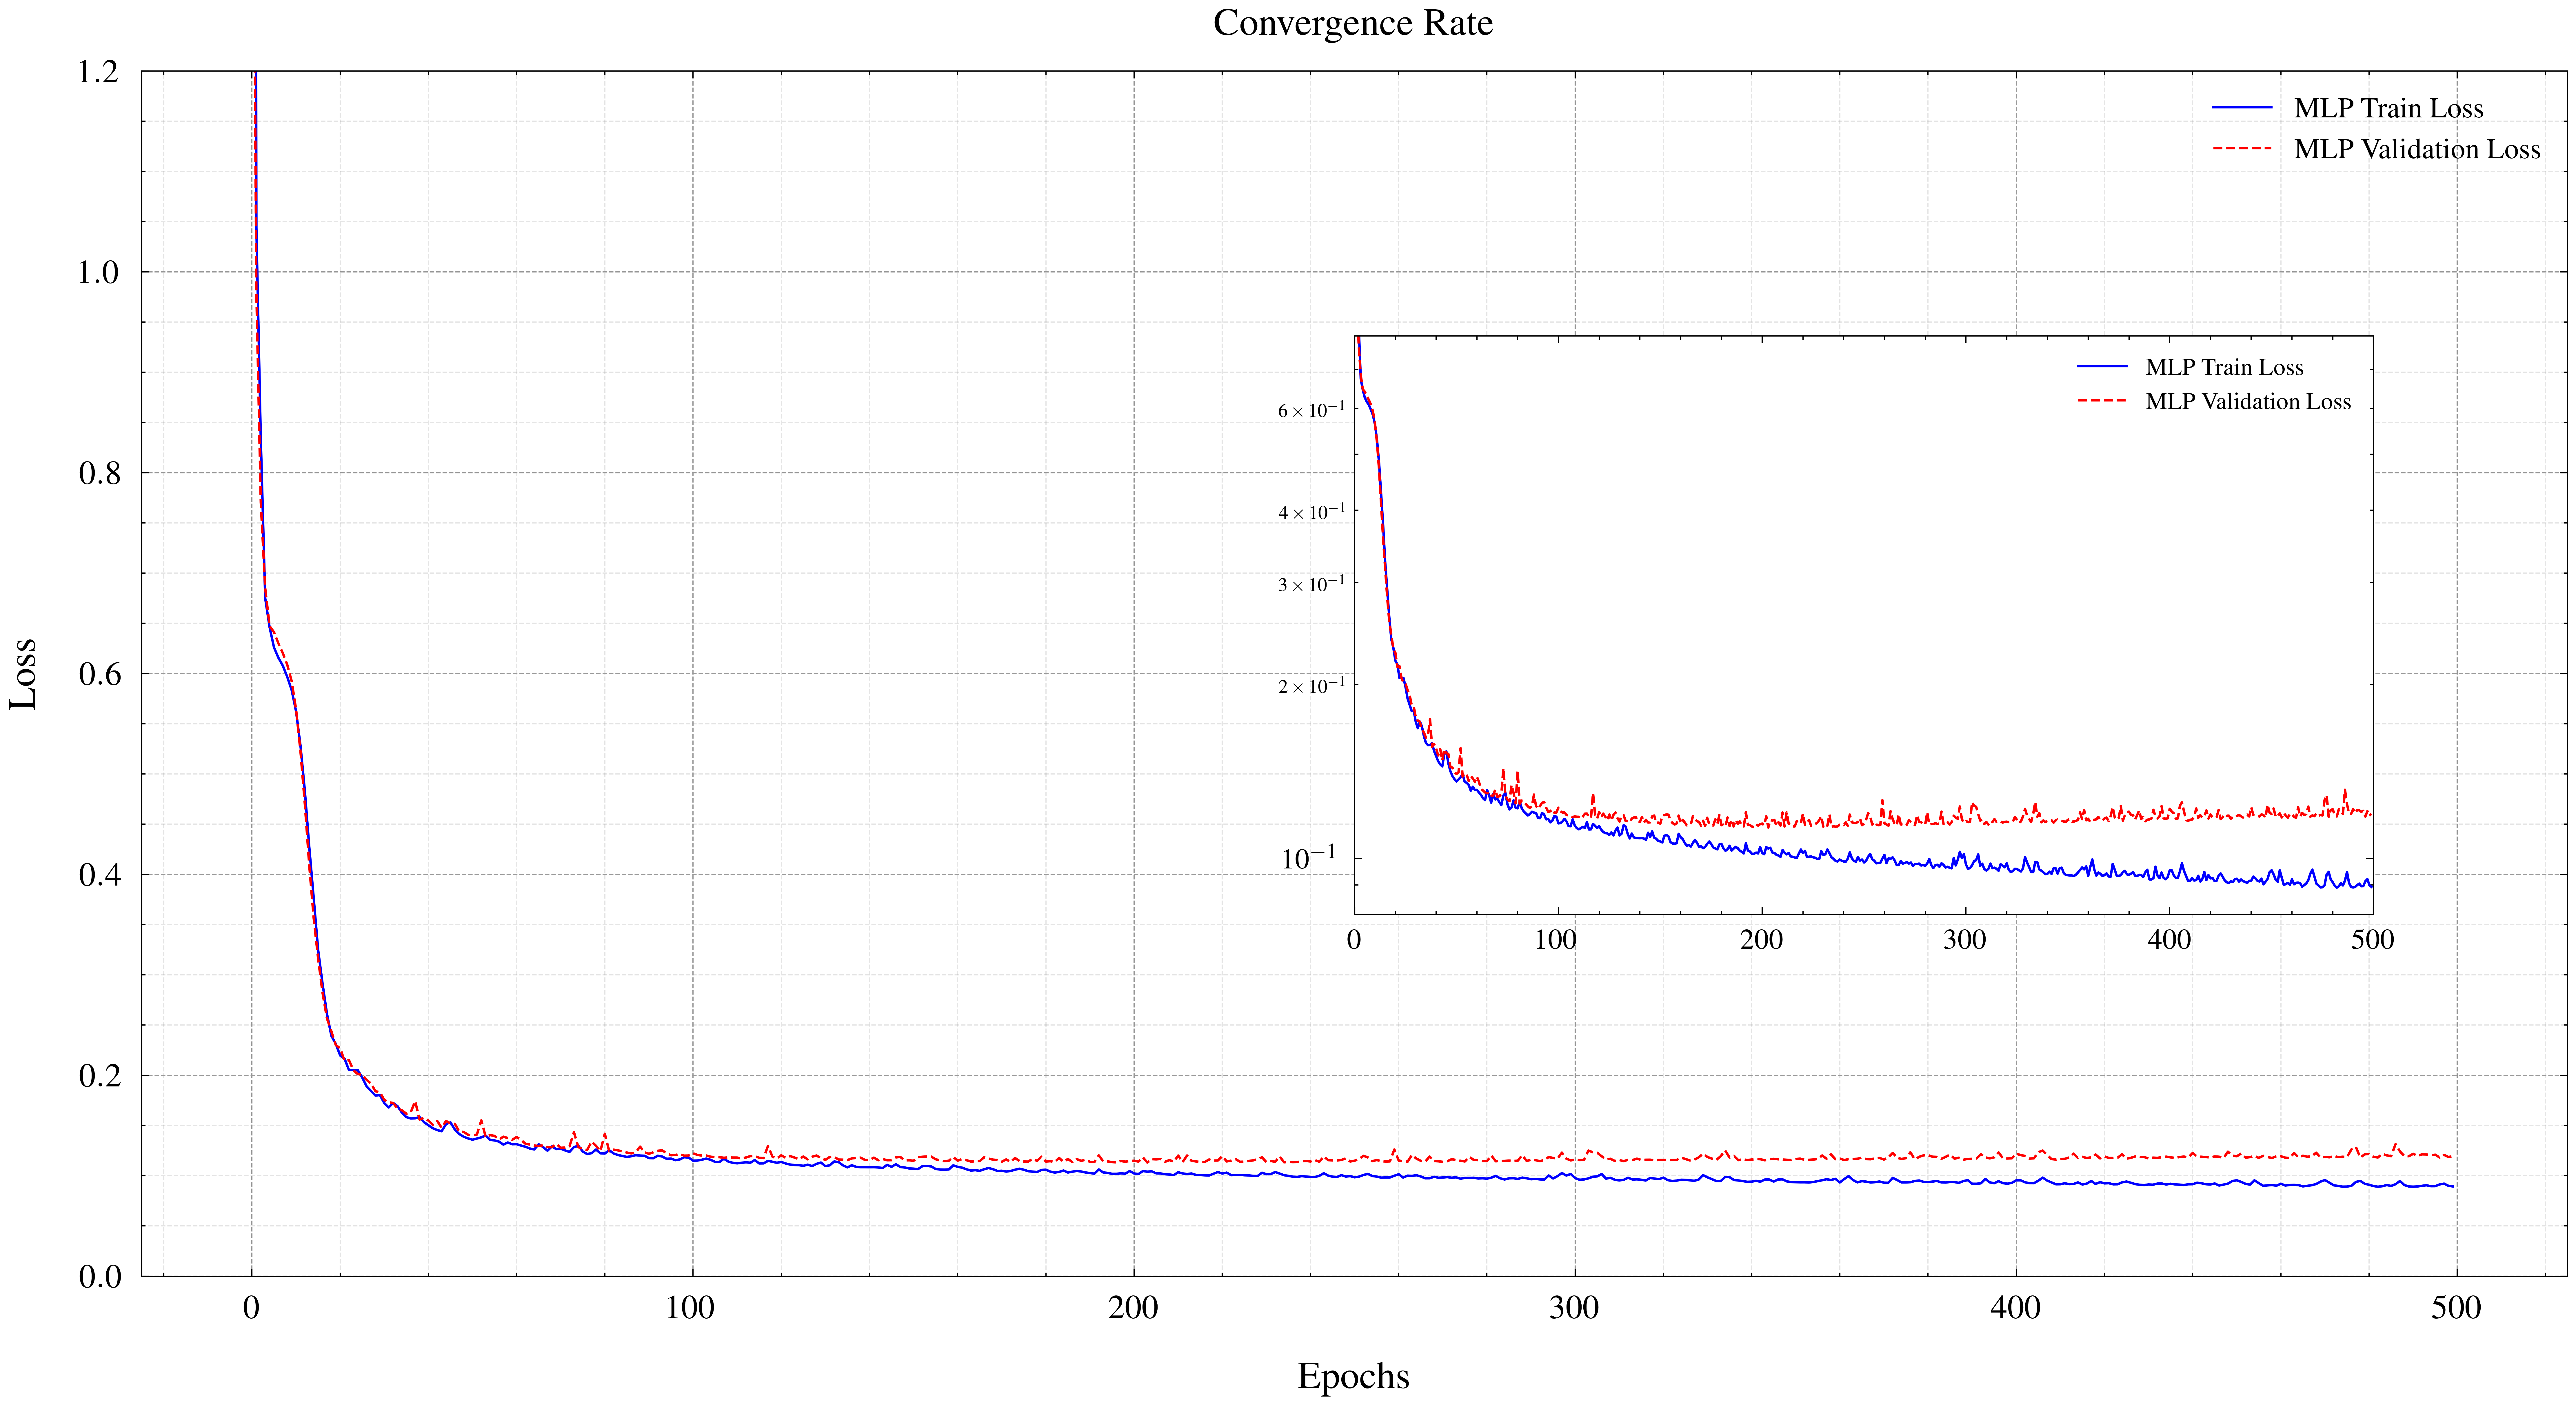

In [220]:
# Convergence rate plots

# bench_losses = read_parquet('losses_benchmark.parquet')
mlp_losses = read_parquet('losses_mlp.parquet')

convergence_rate(losses=[mlp_losses], models=["MLP"], colors=["blue", "red"])

### Testing

In [227]:
# Tested model (if pandas: y = y.iloc[:, [0, 2]] in split_data + alpha = eta in hawkes library)

x = read_parquet("binned_hawkes_simulations_test.parquet")
y = read_parquet('hawkes_hyperparams_test.parquet')

test_x, test_y, _, _, _, _ = split_data(x, y[['eta', 'mu']])
test_y_pred, _, _ = MLPTrainer().test_model(test_x, test_y)
%load_ext tensorboard

Best model loading (2023_05_09_22_01_34_MICSHPEG8GIRARD_best_model.pt)...
Test set - Estimated branching ratio (η): 0.4268, Estimated baseline intensity (µ): 2.8165
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Evaluation

In [139]:
# Computed absolute/relative error + boxplots

# bench_pred = read_parquet('predictions_benchmark.parquet')
mlp_pred = read_parquet('predictions_mlp.parquet')

# bench_errors = compute_errors(bench_pred[['eta_true', 'mu_true']], bench_pred[['eta_pred', 'mu_pred']])
mlp_errors = compute_errors(mlp_pred[['eta_true', 'mu_true']], mlp_pred[['eta_pred', 'mu_pred']], model_name='MLP')

error_boxplots(errors=[mlp_errors], label_names = ["MLP"])

shape: (1, 5)
┌───────┬───────────────────┬───────────────────┬─────────┬─────────┐
│ Model ┆ Error Average (η) ┆ Error Average (μ) ┆ MRE (η) ┆ MRE (μ) │
│ ---   ┆ ---               ┆ ---               ┆ ---     ┆ ---     │
│ str   ┆ f32               ┆ f32               ┆ f32     ┆ f32     │
╞═══════╪═══════════════════╪═══════════════════╪═════════╪═════════╡
│ MLP   ┆ -0.005            ┆ -0.0195           ┆ 0.0974  ┆ 0.0224  │
└───────┴───────────────────┴───────────────────┴─────────┴─────────┘


### Deltas Tests

In [125]:
# Tests and comparison (Testing Effects of Parameters = β, η, ∆, E)

# Intensity Decay Parameter (β) = U(p = 1, q = 3)
# Branching Ratio (η) = U(a = 0.2, b = 0.6)
# Expected Activity (E) = 500
# Time Horizon (T) = 100
# Number of processes = 200
# Number of tests = 100

# Intensity Decay Parameter (β) | Branching Ratio (η) | Interval Length (∆) | Expected Activity (E)
                                                                   
#          [0.5,2.5]                   [0.1,0.4]               0.25                   50
#         [1.75,3.75]                  [0.3,0.6]               0.5                    100
#            [3,5]                     [0.5,0.8]                1                     250
#           [0.5,3]                    [0.1,0.6]                2                     500
#           [1.5,4]                    [0.2,0.7]                5                     1000
#           [2.5,5]                    [0.3,0.8]
#           [0.5,4]                    [0.05,0.6]
#           [1.5,5]                    [0.05,0.7]
#           [0.5,5]                    [0.05,0.8]

# Run
deltas_discret_simulated_events_seqs = delta_simulations()

In [133]:
read_parquet("binned_hawkes_simulations_delta_0.25.parquet")

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,…,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399
f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,2.0,1.0,6.0,4.0,0.0,1.0,3.0,0.0,2.0,1.0,2.0,3.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,2.0,6.0,1.0,0.0,2.0,1.0,2.0,…,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,3.0,0.0,2.0,0.0,0.0,3.0,0.0,1.0,2.0,0.0,0.0,1.0,2.0,2.0,8.0,3.0,1.0,1.0,4.0
3.0,4.0,4.0,0.0,1.0,1.0,2.0,1.0,0.0,2.0,2.0,0.0,1.0,3.0,0.0,3.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,1.0,0.0,3.0,2.0,1.0,1.0,0.0,2.0,0.0,1.0,3.0,3.0,2.0,…,1.0,0.0,3.0,3.0,0.0,1.0,1.0,2.0,0.0,2.0,0.0,1.0,0.0,2.0,3.0,0.0,1.0,4.0,2.0,2.0,2.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,1.0
1.0,0.0,1.0,3.0,2.0,1.0,3.0,4.0,3.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,4.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,3.0,1.0,2.0,0.0,0.0,1.0,…,2.0,1.0,0.0,0.0,0.0,0.0,4.0,4.0,1.0,3.0,2.0,1.0,3.0,1.0,0.0,1.0,0.0,1.0,1.0,2.0,1.0,4.0,5.0,1.0,2.0,3.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0
1.0,1.0,0.0,2.0,1.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,4.0,3.0,4.0,2.0,4.0,2.0,3.0,3.0,4.0,3.0,3.0,4.0,4.0,0.0,3.0,6.0,1.0,2.0,0.0,…,2.0,2.0,1.0,1.0,0.0,3.0,4.0,2.0,2.0,0.0,0.0,1.0,4.0,1.0,2.0,0.0,1.0,1.0,2.0,1.0,3.0,2.0,1.0,2.0,6.0,1.0,5.0,4.0,3.0,1.0,1.0,3.0,3.0,0.0,2.0,1.0,1.0
0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,1.0,2.0,0.0,1.0,2.0,1.0,1.0,3.0,4.0,3.0,2.0,1.0,4.0,8.0,5.0,4.0,1.0,4.0,2.0,7.0,1.0,2.0,0.0,3.0,3.0,0.0,4.0,2.0,…,1.0,4.0,2.0,2.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,1.0,3.0,2.0,0.0,1.0,3.0,0.0,2.0,0.0,0.0,2.0,3.0,0.0,3.0,3.0,3.0,2.0,2.0,2.0,1.0,2.0
3.0,2.0,3.0,1.0,2.0,3.0,0.0,2.0,4.0,1.0,4.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,2.0,4.0,0.0,0.0,0.0,1.0,1.0,4.0,2.0,1.0,1.0,0.0,1.0,1.0,…,1.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,4.0,3.0,1.0,2.0,3.0,1.0,1.0,3.0,2.0,0.0,1.0,1.0,4.0,2.0,1.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,2.0
2.0,1.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,2.0,3.0,2.0,1.0,3.0,1.0,4.0,4.0,0.0,2.0,1.0,2.0,1.0,3.0,2.0,1.0,2.0,0.0,0.0,2.0,…,0.0,3.0,4.0,7.0,3.0,2.0,6.0,4.0,2.0,3.0,2.0,0.0,2.0,1.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,2.0,2.0,1.0,0.0,1.0,0.0,1.0,1.0,5.0,1.0,4.0,4.0,3.0
1.0,2.0,0.0,3.0,1.0,2.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,3.0,0.0,3.0,0.0,1.0,2.0,0.0,3.0,2.0,4.0,5.0,2.0,3.0,1.0,0.0,2.0,1.0,0.0,2.0,1.0,2.0,0.0,0.0,1.0,…,2.0,1.0,0.0,1.0,2.0,0.0,3.0,1.0,1.0,0.0,1.0,2.0,2.0,0.0,1.0,2.0,4.0,1.0,3.0,0.0,0.0,2.0,4.0,1.0,3.0,1.0,5.0,2.0,2.0,1.0,3.0,1.0,2.0,0.0,4.0,2.0,4.0
0.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,2.0,1.0,4.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,…,1.0,1.0,0.0,2.0,2.0,2.0,0.0,0.0,2.0,1.0,1.0,2.0,0.0,2.0,1.0,3.0,2.0,0.0,2.0,1.0,2.0,3.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,2.0,1.0


[[array([3, 4, 3, 4, 1, 1, 0, 4, 2, 0, 1, 0, 1, 0, 0, 0, 0, 2, 0, 1, 3, 1,
         1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 0, 2, 1, 0, 2, 0, 1, 2, 0, 1, 2, 2,
         5, 4, 1, 4, 2, 1, 4, 3, 0, 0, 2, 1, 0, 4, 4, 3, 3, 0, 1, 0, 1, 0,
         1, 3, 1, 1, 3, 1, 0, 2, 1, 2, 0, 0, 1, 0, 0, 0, 0, 2, 2, 2, 2, 1,
         0, 4, 2, 0, 0, 0, 2, 1, 0, 2, 0, 0, 2, 3, 0, 0, 1, 1, 1, 2, 2, 1,
         3, 5, 0, 1, 1, 0, 1, 1, 2, 1, 7, 2, 1, 0, 3, 2, 1, 2, 3, 3, 1, 1,
         1, 0, 1, 0, 1, 2, 0, 2, 1, 3, 1, 0, 2, 0, 1, 1, 3, 0, 1, 0, 2, 0,
         0, 0, 2, 1, 0, 1, 1, 0, 1, 1, 2, 3, 1, 3, 2, 1, 2, 2, 1, 2, 1, 3,
         1, 3, 0, 2, 0, 3, 2, 2, 0, 1, 2, 0, 1, 1, 1, 2, 0, 5, 5, 4, 1, 0,
         1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 2, 1, 2, 3, 1, 0, 0, 1, 0, 2, 0, 2,
         4, 2, 0, 2, 1, 1, 1, 1, 2, 2, 5, 2, 0, 1, 0, 0, 0, 0, 1, 4, 0, 0,
         0, 0, 1, 1, 3, 0, 1, 2, 3, 3, 2, 2, 2, 3, 1, 2, 1, 1, 0, 0, 0, 1,
         2, 2, 1, 0, 1, 0, 0, 2, 1, 0, 1, 1, 1, 2, 0, 2, 2, 0, 0, 3, 0, 1,
         0, 0, 3, 2, 0, 1